In [12]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [2]:
run_dir = f"{results_dir}run_ring_k1_1_k2s_ic_random_tend_600.0_nreps_10000_di/"
file_name = f"{run_dir}thetas_arr_ring_k1_1_k2s_ic_random_tend_600.0_nreps_10000_di.npy"

data = np.load(file_name) # end states

file_name = f"{run_dir}df_long_ring_k1_1_k2s_ic_random_tend_600.0_nreps_10000_di.csv"

df = pd.read_csv(file_name, index_col=0)



In [4]:
data[-2].shape

(10000, 100)

In [40]:
mask_pos = df["state"].str.startswith('-')  # Create a mask for rows where "state" starts with "-"
mask_sync = df["state"] != "sync"
mask = ~mask_pos * mask_sync
masked_df = df[mask]

(6.32256387022507e-05, 1.1)

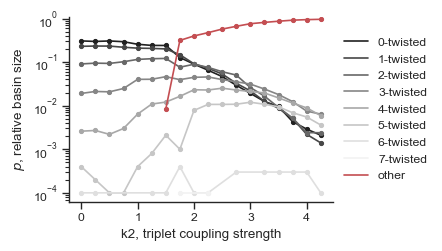

In [203]:
labels = [f"{i}-twisted" for i in range(8)] + ["other"]

fig, ax = plt.subplots(figsize=(3.4, 2.4))
g = sb.lineplot(
    data=df[mask],
    x="k2",
    y="proba",
    hue="state",
    marker="o",
    ax=ax,
    #alpha=0.7,
    #style="state",
    dashes=False,
    hue_order=labels,
    ms=3,
    mec=None,
    #mfc="w",
    palette=sb.color_palette("Greys_r", n_colors=len(labels)-1) + ["r"]
)

g.set(yscale="log")
sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="")

ax.set_xlabel("k2, triplet coupling strength")
ax.set_ylabel("$p$, relative basin size")

sb.despine()
ax.set_ylim(ymax=1.1)

/var/folders/wm/5gv37br900l73y63tjf8sr1r0000gn/T/ipykernel_28450/4277600188.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twisted["q"] = df_twisted["state"].str[:-8].astype(int)


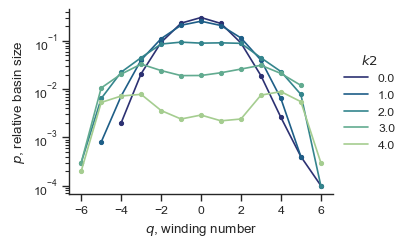

In [215]:
mask_k2 = df["k2"].isin(np.arange(0, 4))
mask_other = df["state"] != "other"

mask_twisted = df["state"].str.contains("twisted")
df_twisted = df[mask_twisted]
df_twisted["q"] = df_twisted["state"].str[:-8].astype(int)
mask_k2 = df_twisted["k2"].isin(np.arange(0, 5))


fig, ax = plt.subplots(figsize=(3.4, 2.4))
g = sb.lineplot(
    data=df_twisted[mask_k2],
    hue="k2",
    y="proba",
    x="q",
    marker="o",
    ms=3,
    #mfc="w",
    mec=None,
    ax=ax,
    #alpha=0.7,
    #style="k2",
    dashes=False,
    #hue_order=[0, 1, 2, 3, 4],
    legend="full",
    palette="crest_r"
)

g.set(yscale="log")
sb.move_legend(g, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, title="$k2$")


sb.despine()

#plt.xticks(rotation=45)
ax.set_xlabel("$q$, winding number")
ax.set_ylabel("$p$, relative basin size")

plt.show()